In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from utils import AreaEnergy, TSF

공대7호관_HV_02 = AreaEnergy('공대7호관.HV_02',
                         path_time=r"/home/dspserver/andrew/dataset/Electricity data_CNU/3.unit of time(일보)/")

2022-06-10 00:59:46.974744: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


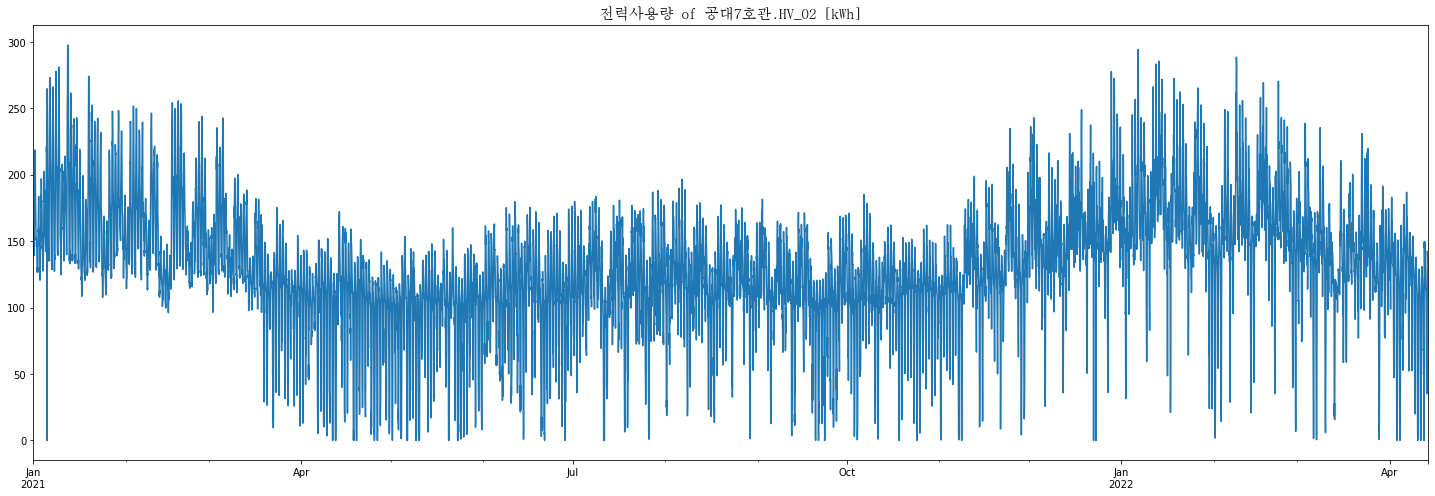

In [3]:
공대7호관_HV_02.plot_sequence()

In [4]:
input_width = 12
label_width = 1
num_features = 1

tsf = TSF(공대7호관_HV_02.arr_seq_dataset, batch_size=32, shift=1, shuffle=False, input_width=input_width,
          label_width=label_width)

Inputs shape (batch, time, features): (32, 12, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [73]:
# from utils import TSF_Data


from sklearn.model_selection import train_test_split
class TSF_Data:
    """
    This class only support to prepare training (backup to TSF class)
    """

    def __init__(self, data, input_width: int, output_width: int, shift=1, batch_size=32, train_ratio=None, shuffle=False):
        """
        return:
        data_train,
        data_valid,
        data_test
        """
        self.data_train = None
        self.data_test = None
        self.scaler_x = None
        self.scaler_y = None
        self.raw_data = data
        self.input_width = input_width
        self.output_width = output_width
        self.shift = shift
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.split_data(train_ratio)
        self.data_train = self.build_tsd(self.X_train)
        self.data_valid = self.build_tsd(self.X_valid)
        if self.X_test is not None:
            self.data_test = self.build_tsd(self.X_test)
        else:
            self.data_test = None

        self.normalize_data()

    def split_data(self, train_ratio):
        self.X_test = None  # No testing, using whole data to train
        X_train = self.raw_data
        if train_ratio is not None:
            X_train, self.X_test = train_test_split(
                self.raw_data, train_size=train_ratio, shuffle=self.shuffle)
        self.X_train, self.X_valid = train_test_split(
            X_train, train_size=0.9, shuffle=self.shuffle)
    
    def inverse_scale_transform(self, y_predicted):
        """
        un-scale predicted output 
        """
        if self.scaler_y is not None:
            return self.scaler_y.inverse_transform(y_predicted)
        return y_predicted

    def normalize_data(self):
        """The mean and standard deviation should only be computed using the training data so that the models
        have no access to the values in the validation and test sets."""
        from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler, PowerTransformer
        scaler_x = MinMaxScaler()
        scaler_x.fit(self.data_train[0])
        scaler_y = MinMaxScaler()
        scaler_y.fit(self.data_train[1])
        self.scaler_x = scaler_x
        self.scaler_y = scaler_y

        # self.data_train = scaler_x.transform(
        #     self.data_train[0]), scaler_y.transform(self.data_train[1])
        # # converting into L.S.T.M format
        # self.data_train = self.data_train[0], self.data_train[1]
        # self.data_valid = scaler_x.transform(
        #     self.data_valid[0]), scaler_y.transform(self.data_valid[1])
        # self.data_valid = self.data_valid[0], self.data_valid[1]
        # if self.data_test is not None:
        #     self.data_test = scaler_x.transform(
        #         self.data_test[0]), scaler_y.transform(self.data_test[1])
        #     self.data_test = self.data_test[0], self.data_test[1]
        self.data_train = scaler_x.transform(
        self.data_train[0]), scaler_y.transform(self.data_train[1])
        # converting into L.S.T.M format
        self.data_train = self.data_train[0][...,
                                             np.newaxis], self.data_train[1]
        self.data_valid = scaler_x.transform(
            self.data_valid[0]), scaler_y.transform(self.data_valid[1])
        self.data_valid = self.data_valid[0][...,
                                             np.newaxis], self.data_valid[1]
        if self.data_test is not None:
            self.data_test = scaler_x.transform(
                self.data_test[0]), scaler_y.transform(self.data_test[1])
            self.data_test = self.data_test[0][...,
                                               np.newaxis], self.data_test[1]

    def build_tsd(self, data):
        X_data, y_label = [], []

        for i in range(self.input_width, len(data) - self.output_width):
            X_data.append(data[i - self.input_width:i])
            y_label.append(data[i:i + self.output_width])

        X_data, y_label = np.array(X_data), np.array(y_label)

        # converting into L.S.T.M format
        # X_data = X_data.reshape(X_data.shape[0], X_data.shape[1], 1)

        # here our y_train is not in 3D structure
        # y_label = y_label.reshape(y_label.shape[0], y_label.shape[1])
        return X_data, y_label
        
tsf = TSF_Data(data=공대7호관_HV_02.arr_seq_dataset,
               input_width=21,
               output_width=1,
               train_ratio=0.9)

In [74]:
import tensorflow as tf
from tcn import TCN
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input


input_width = tsf.data_train[0].shape[1]
num_features = 1

inputs = Input(shape=(input_width, num_features))

x1 = TCN(input_shape=(input_width, 1),
         kernel_size=2,
         use_skip_connections=False,
         use_batch_norm=False,
         use_weight_norm=False,
         use_layer_norm=False
         )(inputs)

x2 = Dense(units=1, activation='linear')(x1)

model = Model(inputs, x2)

model.summary()
model.compile('adam', 'mae')

checkpoint_path = "CNU_1/cp.ckpt"

print('Train...')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min')

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='min')

reduceLR = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
callbacks = [
    early_stopping,
    reduceLR
]

history = model.fit(x=tsf.data_train[0],
                    y=tsf.data_train[1],
                    validation_data=tsf.data_valid,
                    epochs=50,
                    callbacks=[callbacks],
                    verbose=2,
                    use_multiprocessing=True)


Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 21, 1)]           0         
                                                                 
 tcn_19 (TCN)                (None, 64)                91136     
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 91,201
Trainable params: 91,201
Non-trainable params: 0
_________________________________________________________________
Train...
Epoch 1/50
284/284 - 5s - loss: 0.2196 - val_loss: 0.0521 - lr: 0.0010 - 5s/epoch - 19ms/step
Epoch 2/50
284/284 - 4s - loss: 0.0538 - val_loss: 0.0560 - lr: 0.0010 - 4s/epoch - 13ms/step
Epoch 3/50
284/284 - 4s - loss: 0.0493 - val_loss: 0.0445 - lr: 0.0010 - 4s/epoch - 13ms/step
Epoch 4/50
284/284 - 4s - l

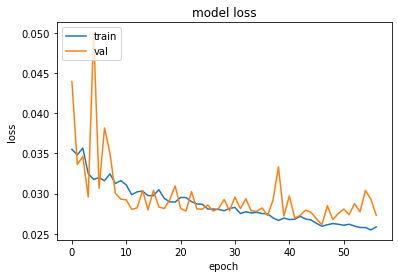

In [12]:
# summarize history for loss
plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## MinMaxScaler

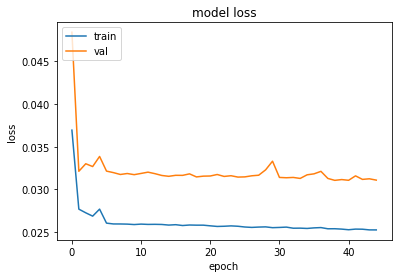

284/284 [==============================] - 2s 6ms/step


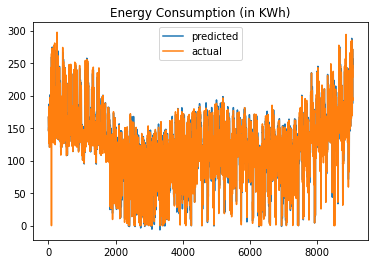

1102/1102 - 6s - loss: 0.0281 - 6s/epoch - 6ms/step


0.028097130358219147

In [75]:
# summarize history for loss
plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

p = tsf.inverse_scale_transform(model.predict(tsf.data_train[0]))

y_label = tsf.inverse_scale_transform(tsf.data_train[1])
plt.plot(p)
plt.plot(y_label)
plt.title('Energy Consumption (in KWh)')
plt.legend(['predicted', 'actual'])
plt.show()


model.evaluate(tsf.data_test[0],tsf.data_test[1], batch_size=1,
               verbose=2,
               use_multiprocessing=True)

284/284 [==============================] - 2s 6ms/step


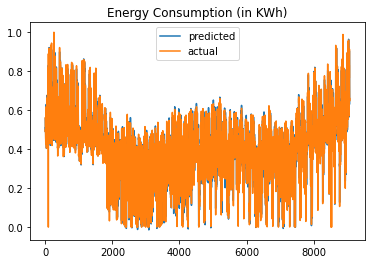

1102/1102 - 6s - loss: 0.0278 - 6s/epoch - 6ms/step


0.027805082499980927

In [21]:
tsf.data_train[0].shape

(9075, 21, 1)

In [55]:
tsf.inverse_scale_transform(model.predict(tsf.data_test[0]))

35/35 [==============================] - 0s 5ms/step


array([[157.01097],
       [150.53659],
       [147.78261],
       ...,
       [135.5795 ],
       [140.22096],
       [136.52733]], dtype=float32)

## Normalizer

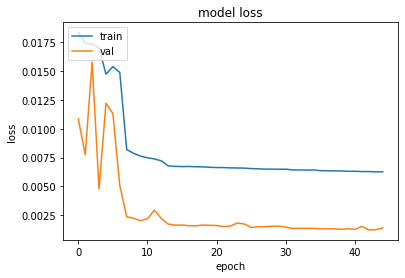

284/284 [==============================] - 2s 6ms/step


AttributeError: 'Normalizer' object has no attribute 'inverse_transform'

In [72]:
# summarize history for loss
plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

p = tsf.inverse_scale_transform(model.predict(tsf.data_train[0]))

y_label = tsf.inverse_scale_transform(tsf.data_train[1])
plt.plot(p)
plt.plot(y_label)
plt.title('Energy Consumption (in KWh)')
plt.legend(['predicted', 'actual'])
plt.show()

model.evaluate(tsf.data_test[0],tsf.data_test[1], batch_size=1,
               verbose=2,
               use_multiprocessing=True)

## StandardScaler

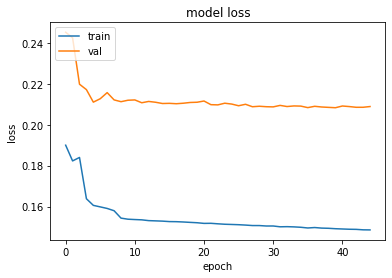

284/284 [==============================] - 2s 6ms/step


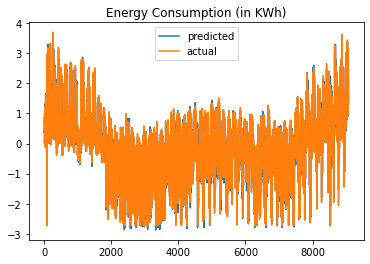

1102/1102 - 6s - loss: 0.1942 - 6s/epoch - 6ms/step


0.1942327469587326

In [61]:
# summarize history for loss
plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

p = model.predict(tsf.data_train[0])

y_label = tsf.data_train[1]
plt.plot(p)
plt.plot(y_label)
plt.title('Energy Consumption (in KWh)')
plt.legend(['predicted', 'actual'])
plt.show()

model.evaluate(tsf.data_test[0],tsf.data_test[1], batch_size=1,
               verbose=2,
               use_multiprocessing=True)

##  RobustScaler

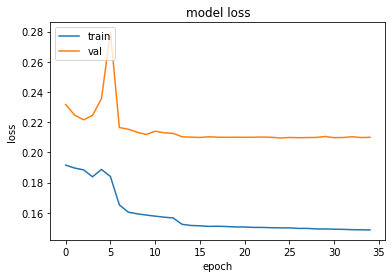

284/284 [==============================] - 2s 6ms/step


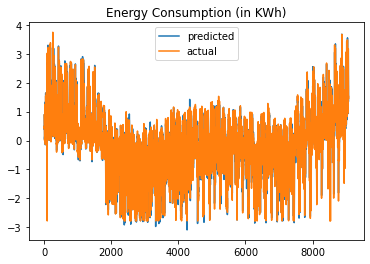

1102/1102 - 6s - loss: 0.1972 - 6s/epoch - 6ms/step


0.19718390703201294

In [64]:
# summarize history for loss
plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

p = model.predict(tsf.data_train[0])

y_label = tsf.data_train[1]
plt.plot(p)
plt.plot(y_label)
plt.title('Energy Consumption (in KWh)')
plt.legend(['predicted', 'actual'])
plt.show()

model.evaluate(tsf.data_test[0],tsf.data_test[1], batch_size=1,
               verbose=2,
               use_multiprocessing=True)

## PowerTransformer

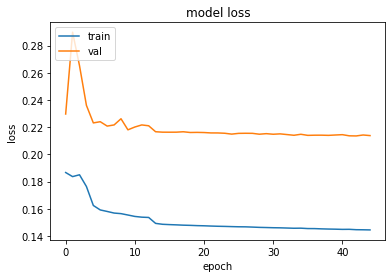

284/284 [==============================] - 1s 5ms/step


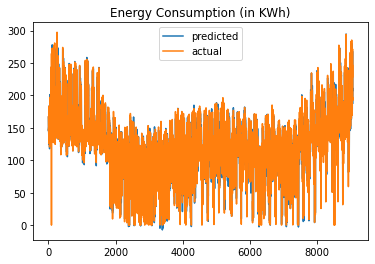

1102/1102 - 6s - loss: 0.1942 - 6s/epoch - 6ms/step


0.19420656561851501

In [69]:
# summarize history for loss
plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

p = tsf.inverse_scale_transform(model.predict(tsf.data_train[0]))

y_label = tsf.inverse_scale_transform(tsf.data_train[1])
plt.plot(p)
plt.plot(y_label)
plt.title('Energy Consumption (in KWh)')
plt.legend(['predicted', 'actual'])
plt.show()

model.evaluate(tsf.data_test[0],tsf.data_test[1], batch_size=1,
               verbose=2,
               use_multiprocessing=True)

In [68]:
tsf.inverse_scale_transform(model.predict(tsf.data_test[0]))

35/35 [==============================] - 0s 6ms/step


array([[157.24965],
       [151.2192 ],
       [148.37784],
       ...,
       [136.00615],
       [138.16951],
       [135.4349 ]], dtype=float32)